## Imports

In [1]:
#%pip install taichi
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports

# From python
import math
import time
import numpy as np
import os
import multiprocessing
from typing import Callable

# From External Libraries
from tqdm.notebook import tqdm
# import pandas as pd
from  matplotlib import pyplot as plt

# From libraries to test

## Numba
import numba
from numba import njit, prange

## Jax


## Taichi
import taichi as ti

[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.11.10


[I 06/13/25 09:59:51.614 395684] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Setup Functions

In [2]:
def validate_acceleration( method1: Callable, method2: Callable, X: np.
ndarray ) -> bool:
    result1 = method1(X)
    result2 = method2(X)

    return np.allclose(result1, result2)


To start we decide to implement a naive loops algorithm to make sure our numpy implementation is correct, and we also had some curiosity on its speed differences. In the graphs it will be called "Loops".

In [50]:
# Implement acceleration just using pythonic loops
def get_acceleration_naive_loops(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i, ri in enumerate(X):

        sum = np.zeros(3)
        for j, rj in enumerate(X):
            if i == j:
                continue
            diff = rj - ri
            cube = np.linalg.norm(diff) ** 3
            sum += diff / cube

        acceleration[i] = -sum

    return acceleration


Now we use only Numpy package functions instead. In the graphs it is called "Numpy".

In [2]:
# Implement using np arrays and broadcasting
def get_acceleration_numpy(X: np.ndarray) -> np.ndarray:
    vec_diff = X[:, np.newaxis] - X
    distance_matrix = np.linalg.norm(vec_diff, axis=2) ** 3

    # Set distance 0 to inf to avoid dividing by 0
    distance_matrix[distance_matrix == 0] = np.inf

    acceleration = vec_diff / distance_matrix[:, :, np.newaxis]

    return -np.sum(acceleration, axis=0)

In [16]:
a = np.array([[0, 0, 0],[16, 18.5, 20],[3,4,5],[10,10,15]], dtype=float)
validate_acceleration(get_acceleration_numpy, get_acceleration_naive_loops, a)

True

In [6]:
@njit
def get_acceleration_naive_loops_numba(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in range(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba loops:",validate_acceleration(get_acceleration_naive_loops_numba, get_acceleration_numpy, a))



# Use the same code as above just changing range for prange and setting the njit property
@njit(parallel=True)
def get_acceleration_numba_parallel(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in prange(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
# print("Numba parallel:",validate_acceleration(get_acceleration_numba_parallel, get_acceleration_numpy, a))



## set up jax

In [21]:
import jax.numpy as jnp
import jax

# @jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return jax.vmap(get_i)(jnp.arange(N))  # Vectorized version for parallel execution


# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
get_acceleration_jax_cpu = jax.jit(get_acceleration_jax, backend='cpu')
get_acceleration_jax_gpu = jax.jit(get_acceleration_jax, backend="gpu")



## Setup taichi

In [4]:
# ti.init(arch=ti.cpu, default_fp=ti.f32)  # Use GPU (or ti.cpu for CPU)
ti.init(arch=ti.cpu, default_fp=ti.f64)  # Use GPU (or ti.cpu for CPU)
# ti.init(arch=ti.gpu)  # Use GPU (or ti.cpu for CPU)

def get_acceleration_taichi(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float64)
    n=X.shape[0]

    positions = ti.Vector.field(3, dtype=ti.f64, shape=n)
    acceleration = ti.Vector.field(3, dtype=ti.f64, shape=n)
    
    positions.from_numpy(X)


    @ti.kernel
    def compute_acceleration():
        n = positions.shape[0]
        for i in positions:
            sum_force = ti.math.vec3(0.0)
            for j in range(n):
                if i != j:
                    r = positions[j] - positions[i]
                    r_norm = r.norm()
                    # sum_force += r / (r_norm**3 + 1e-5*r_norm**2)
                    sum_force += r / (r_norm**3 )
            acceleration[i] = -sum_force
    
    compute_acceleration()
    return acceleration.to_numpy()


[Taichi] Starting on arch=x64


In [28]:
validate_acceleration(get_acceleration_numpy, get_acceleration_taichi, a.astype(np.float32))

True

In [ ]:
# ti.init(arch=ti.cpu, default_fp=ti.f32)  # Use GPU (or ti.cpu for CPU)
ti.init(arch=ti.gpu, default_fp=ti.f32)  # Use GPU (or ti.cpu for CPU)
# ti.init(arch=ti.gpu)  # Use GPU (or ti.cpu for CPU)
# ti.get_runtime().core.set_capability(ti.core.Capability.vulkan_64bit)


def get_acceleration_taichi(X: np.ndarray) -> np.ndarray:
    X = X.astype(np.float32)
    n=X.shape[0]

    positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
    acceleration = ti.Vector.field(3, dtype=ti.f32, shape=n)
    
    positions.from_numpy(X)


    @ti.kernel
    def compute_acceleration():
        n = positions.shape[0]
        for i in positions:
            sum_force = ti.math.vec3(0.0)
            for j in range(n):
                if i != j:
                    r = positions[j] - positions[i]
                    r_norm = r.norm()
                    # sum_force += r / (r_norm**3 + 1e-5*r_norm**2)
                    sum_force += r / (r_norm**3 )
            acceleration[i] = -sum_force
    
    compute_acceleration()
    return acceleration.to_numpy()


NameError: name 'ti' is not defined

A little test to check on 4 simple points if the two methods return the same results.
So that we can confirm that our Numpy implementation is correct.

## Task 2. Verify method complexity

> Verify that the method indeed has complexity $O(N^2)$ by running the function for different
values of N and measuring the time taken to calculate the accelerations. Use to generate the positions of the bodies from a Gaussian distribution here and below. Make a
log-log-plot of the time taken to calculate the accelerations as a function of N. 

Here we define the *time_algorithm* method that measures the time an implementation takes on a specific input. The *verify_complexity* method captures the time the algorithms take when varying the problem size. When we define a new algorithm, we will display these values on a plot using the *plot_table* and *plot_complexity* methods.

In [7]:
import gc
import sys
from sys import getsizeof
def time_algorithm(N, algo):
    X = np.random.rand(N, 3)
    print(f"N:{N:_} size:{getsizeof(X)/(1024**2):.2f} MB, sizenp:{X.nbytes/(1024**2):.2f}")
    start = time.time()
    r = algo(X)
    elapsed_time = time.time() - start
    print(sys.getrefcount(r), sys.getrefcount(X))
    # r.resize((0, 0), refcheck=False) 
    # X.resize((0, 0), refcheck=False) 
    del r
    del X
    gc.collect()
    return elapsed_time


def verify_complexity(algo, steps=20, starting_size=20):
    wtime = []
    n_values = [int(starting_size * 2 ** i) for i in range(1, steps)]
    tested_n = []
    for N in n_values:
        elapsed_time = time_algorithm(N, algo)
        wtime.append(elapsed_time)
        tested_n.append(N)
        if elapsed_time > 10:
            break
    return tested_n, wtime


def plot_table(n_values, wtime, algorithm_name):
    df = pd.DataFrame({"N": n_values, "time": wtime})
    print(f"Table for {algorithm_name} algorithm")
    display(df)



def plot_complexity(algorithms_data):
    plt.figure(figsize=(10,10))
    for algo,(n_values, wtime) in algorithms_data.items():
        plt.plot(n_values, wtime, marker="o", label=algo)
        for x,y in zip(n_values, wtime):
            plt.text(x,y, f"{x:.0e}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("log N")
    plt.ylabel("log time")
    plt.grid()
    plt.legend()
    plt.title(f"Acceleration algorithm(s) complexity analysis")
    plt.show()


Here we run and plot the first two algorithms "Loops" and "Numpy", we used different starting size and step size for the Loops algorithm since it is significantly slower and would run for too long on the same problem size we used for the other algorithms.

In [10]:
steps = 6
starting_size = 1e2
algorithms_complexity = {}

In [11]:
# Algos to meassure
algos = {
    # "Loops":get_acceleration_naive_loops,
    # "Numpy":get_acceleration_numpy,
    # "Numba Loops":get_acceleration_naive_loops_numba,
    # "Numba Parallel":get_acceleration_numba_parallel,
    "Jax CPU2":get_acceleration_jax_cpu,
    # "Jax GPU":get_acceleration_jax_gpu,
    # "Taichi":get_acceleration_taichi,
}

NameError: name 'get_acceleration_jax_cpu' is not defined

In [ ]:
algorithms_complexity["Loops"] = verify_complexity(
    get_acceleration_naive_loops,
    steps=8,
    starting_size=starting_size/2, # This is very slow so start with smaller N
)

In [ ]:
algorithms_complexity["Numpy"] = verify_complexity(
    get_acceleration_numpy,
    steps=7,
    starting_size=starting_size, # This is very slow so start with smaller N
)

In [ ]:
for algo_name, algo_f in algos.items():
    print(algo_name)
    try:
        algorithms_complexity[algo_name] = verify_complexity(
            algo_f,
            steps,
            starting_size,
        )
    except Exception as e:
        print(e)


Jax CPU2
N:200 size:0.00 MB, sizenp:0.00
2 3
N:400 size:0.01 MB, sizenp:0.01
2 3
N:800 size:0.02 MB, sizenp:0.02
2 3
N:1_600 size:0.04 MB, sizenp:0.04
2 3
N:3_200 size:0.07 MB, sizenp:0.07
2 3
N:6_400 size:0.15 MB, sizenp:0.15
2 3
N:12_800 size:0.29 MB, sizenp:0.29
2 3
N:25_600 size:0.59 MB, sizenp:0.59
2 3
N:51_200 size:1.17 MB, sizenp:1.17
2 3


: 

In [9]:
for algo_name, algo_f in algos.items():
    print(algo_name)
    try:
        algorithms_complexity[algo_name] = verify_complexity(
            algo_f,
            steps,
            starting_size,
        )
    except Exception as e:
        print(e)


Numba Parallel
N:200 size:0.00 MB, sizenp:0.00


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2 2
N:400 size:0.01 MB, sizenp:0.01
2 2
N:800 size:0.02 MB, sizenp:0.02
2 2
N:1_600 size:0.04 MB, sizenp:0.04
2 2
N:3_200 size:0.07 MB, sizenp:0.07
2 2
N:6_400 size:0.15 MB, sizenp:0.15
2 2
N:12_800 size:0.29 MB, sizenp:0.29
2 2
N:25_600 size:0.59 MB, sizenp:0.59
2 2


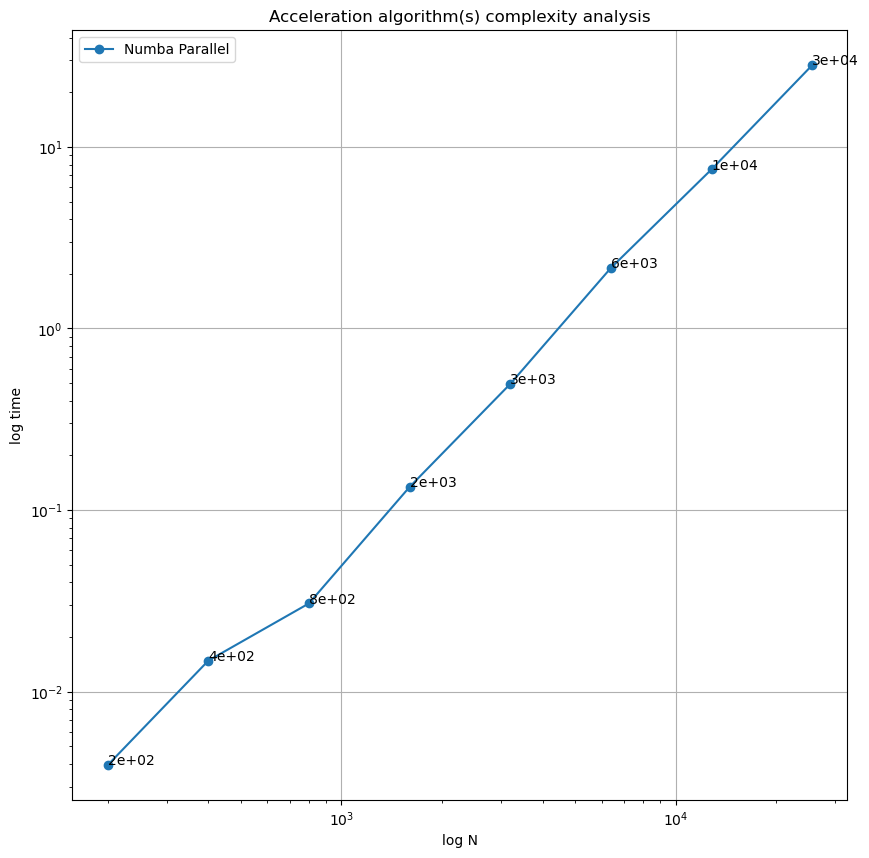

In [19]:
plot_complexity(algorithms_complexity)

We can see, that even with the smaller problem sizes, the Loops algorithm is significantly slower than the Numpy algorithm.

> What is the slope of the line?

In [15]:
def get_slope(algo: str):
    Ns = np.log(algorithms_complexity[algo][0])
    wtime = np.log(algorithms_complexity[algo][1])

    slope, _ = np.polyfit(Ns,wtime, 1)
    return slope

print("Slope for algos:")
for algo in algorithms_complexity:
    print(f"{algo}: {get_slope(algo):.3f}")

Slope for algos:
Loops: 1.769
Numpy: 2.086


## Task 3. Non Parallel Numba

> Write the same function using (non-parallel) Numba and compare the performance of the
numpy and numba-based functions.

In [16]:
@njit
def get_acceleration_naive_loops_numba(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in range(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
get_acceleration_naive_loops_numba(a);

> Repeat the timing measurements for different values of N and insert the results into the plot from the previous
question.

In [17]:
algorithms_complexity["Numba"] = verify_complexity(
    get_acceleration_naive_loops_numba,
    steps,
    starting_size,
)

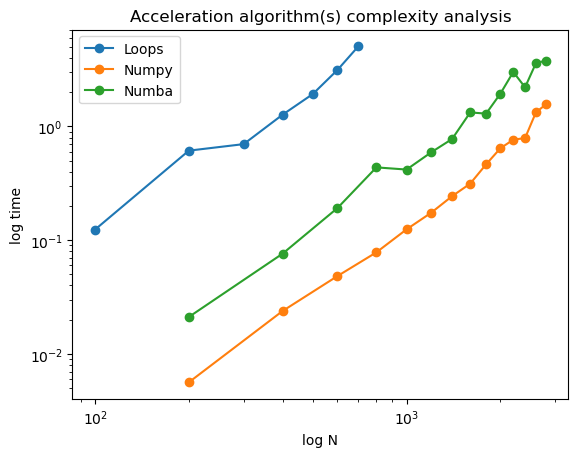

In [18]:
plot_complexity(algorithms_complexity)

We notice that the Numba algorithm without parallelization is slower than the Numpy implementation, but still significantly faster than the "Loops" algorithm. This probably responds to Numba using  loops to do most of the heavy work, while Numpy uses highly optimized c++. We tried to write a Numba function that would use Numpy for the internal loop, but doing a norm over an axis (as we do in the Numpy code) is not yet supported by Numba.


> What is the speedup factor?

In [19]:
def calculate_speedup(algorithms_complexity: dict):
    numpy_sizes, numpy_times = algorithms_complexity['Numpy']
    numba_sizes, numba_times = algorithms_complexity['Numba']
    
    # Calculate speedup factors
    speedup_factors = {size:  numba / numpy for size, numpy, numba in zip(numpy_sizes, numpy_times, numba_times)}
    
    # Print results
    print("Speedup Factors (NumPy vs. Numba):")
    for size, speedup in speedup_factors.items():
        print(f"Problem Size {size}: Speedup = {speedup:.2f}x")
    
    return np.mean([p for p in speedup_factors.values()])

speedup = calculate_speedup(algorithms_complexity)
print(f"Mean speedup: {speedup:.2f}")

Speedup Factors (NumPy vs. Numba):
Problem Size 200: Speedup = 3.75x
Problem Size 400: Speedup = 3.19x
Problem Size 600: Speedup = 3.96x
Problem Size 800: Speedup = 5.58x
Problem Size 1000: Speedup = 3.35x
Problem Size 1200: Speedup = 3.40x
Problem Size 1400: Speedup = 3.18x
Problem Size 1600: Speedup = 4.23x
Problem Size 1800: Speedup = 2.79x
Problem Size 2000: Speedup = 3.02x
Problem Size 2200: Speedup = 3.94x
Problem Size 2400: Speedup = 2.80x
Problem Size 2600: Speedup = 2.71x
Problem Size 2800: Speedup = 2.43x
Mean speedup: 3.45



NumPy is approximately more than **twice as fast** as Numba (without parallelization), although the actual values vary.

We calculate a factor between 2.48 to 2.86 with a mean of 2.73.


## Task 4. Validate Acceleration

> Write a function that validates whether the two functions returned the same results. The
function should have the signature where method1 and method2 are the two functions to be compared and X is the input to the
functions. The function should return True if the two functions return the same results and
False otherwise. Use numpy.allclose to compare the results.


True

>  Do you get the same results?

Yes! It seems that our numpy and numba codes return the same results.
When ignoring the precision errors due to floating point arithmetic.

## Task 5. Parallel Version

> Write a parallel version of the function using Numba and verify correctness of the results.


In [21]:
# Use the same code as above just changing range for prange and setting the njit property
@njit(parallel=True)
def get_acceleration_numba_parallel(X: np.ndarray) -> np.ndarray:
    acceleration = np.zeros(X.shape)
    for i in prange(len(X)):

        sum = np.zeros(3)
        for j in range(len(X)):
            if i == j:
                continue
            diff = X[j] - X[i]
            cube = np.linalg.norm(diff) ** 3
            sum = sum + diff / cube

        acceleration[i] = -sum

    return acceleration

# Run one time to make jit compile the code
get_acceleration_numba_parallel(a);

validate_acceleration(get_acceleration_numba_parallel, get_acceleration_numpy, a)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


True

`validate_acceleration = true`:  We get the same acceleration array as with the Numpy method, our parallel code seems correct.

> Perform a weak and a strong scaling test.

### 4.1 Strong Scaling

We test how the processing time changes on a problem of fixed size while increasing the number of threads.

In [22]:
# For our scaling functions we want a list of number of threads to try up to the available cores.
# We create a list of threads on the powers of 2 up to the number of cores
# We append additionally the max number of cores.as_integer_ratio

max_num_threads = numba.config.NUMBA_NUM_THREADS

# This list-comprehension was created by chatgpt
test_threads = [2**i for i in range(max_num_threads.bit_length()) if 2**i <= max_num_threads]
if test_threads[-1] != max_num_threads:
    test_threads.append(max_num_threads)

In [ ]:
N = 4000  # Fixed problem size
X = np.random.rand(N, 3)
print("Number of max Numba threads :", max_num_threads, "\n")
elapsed_time = 0
for num_threads in test_threads:  
    previous_time = elapsed_time
    numba.set_num_threads(num_threads)  # Set Numba thread count

    start_time = time.time()
    get_acceleration_numba_parallel(X)
    elapsed_time = time.time() - start_time

    print(f"Threads: {num_threads:<2}, Time: {elapsed_time:.4f} sec, SpeedUp from Previous: {previous_time/elapsed_time:.2f}")

Number of max Numba threads : 12 

Threads: 1 , Time: 5.9638 sec, SpeedUp from Previous: 0.00


The computing time loosely halves when the number of threads is doubled. But the number is limited by Amdahl's law.
We notice that increasing the number of threads gives less improvement with every increase.

We tested this in 2 laptops:
* One with max 12 threads(current run): Shows a speedup up to 8 cores, the last 4 cores don't provide much benefit.
* Oen With max 22 Threads shows a similar pattern until 10 cores, but between 10 and 22 the increase was insignificant.

### 4.2 Weak scaling


#### Weak scaling: (threads x2, problem size x2)

We are testing how the processing time changes when both doubling the problem size and the threads working on the problem.

In [ ]:
for num_threads, N in zip(test_threads, [500 * i for i in test_threads]):  # Scale both
    numba.set_num_threads(num_threads)  # Set Numba thread count
    X = np.random.rand(N, 3)  # Increase problem size

    start_time = time.time()
    get_acceleration_numba_parallel(X)
    elapsed_time = time.time() - start_time

    print(f"Threads: {num_threads}, Problem Size: {N}, Time: {elapsed_time:.4f} sec")

Threads: 1, Problem Size: 500, Time: 0.0282 sec
Threads: 2, Problem Size: 1000, Time: 0.0600 sec
Threads: 4, Problem Size: 2000, Time: 0.1499 sec
Threads: 8, Problem Size: 4000, Time: 0.3424 sec
Threads: 12, Problem Size: 6000, Time: 0.7340 sec


When doubling both the problem size and the amount of threads, also the computing time approximately doubles. Starting from 8 threads it slows down a little, from 8 to 16 threads the computing time approximately triples.

#### Weak scaling: (threads x4, problem size x2)

Since we have $O(n^2)$ We expect an increase of problem size of 2 to increase the problem complexity by 4, thus we expect that multiplying the number of threads by 4 should give a close to constant time.

In [ ]:

test_threads_x4 = [(4**i,2**i) for i in range(max_num_threads) if 4**i<=max_num_threads]
if test_threads_x4[-1] != test_threads_x4:
    test_threads_x4.append((max_num_threads,2**math.log(max_num_threads,4)))

# Use multiples of 1000 for number of bodies
test_threads_x4 = [(i,j*1000) for i,j in test_threads_x4]    
test_threads_x4


[(1, 1000), (4, 2000), (12, 3464.101615137755)]

In [ ]:
for num_threads, N in test_threads_x4:  # Scale both
    numba.set_num_threads(num_threads)  # Set Numba thread count
    X = np.random.rand(int(N), 3)  # Increase problem size

    start_time = time.time()
    get_acceleration_numba_parallel(X)
    elapsed_time = time.time() - start_time

    print(f"Threads: {num_threads:<2}, Problem Size: {N:.1f}, Time: {elapsed_time:.4f} sec")

Threads: 1 , Problem Size: 1000.0, Time: 0.1103 sec
Threads: 4 , Problem Size: 2000.0, Time: 0.1504 sec
Threads: 12, Problem Size: 3464.1, Time: 0.2223 sec


We tried to match the complexity of O(N²) by using threads increasing in powers of 4, for a doubling problem size. From one thread with N=1000 to 4 threads and N=2000 the computing time stays constant, but comparing the latter result with 16(Tried on a computer with 22 threads) threads and a problem size of N=4000 the computing time nearly doubles. That follows the trend that starting from 8 threads, increasing the number of threads further only slightly improves the computation speed.

### 4.3 Compare the complexity of all algorithms

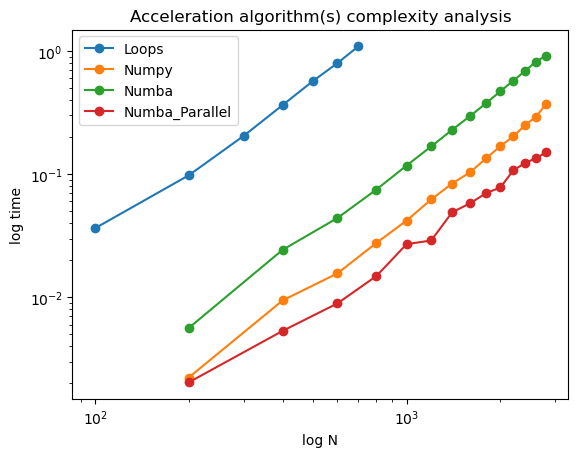

In [ ]:
algorithms_complexity["Numba_Parallel"] = verify_complexity(
    get_acceleration_numba_parallel,
    steps,
    starting_size,
)


plot_complexity(algorithms_complexity)

It can be seen that the parallelized Numba algorithm is significantly faster than all the other implemented algorithms

# Bonus

In [ ]:
# Jax is required:
#%pip install jax

In [36]:
import jax.numpy as jnp
import jax

# @jax.jit # Dont use the annotation to be able to compile for gpu and cpu
def get_acceleration_jax(X: np.ndarray) -> np.ndarray:
    N = len(X)

    def get_i(i):  # Kernel executed in parallel

        vec_diff = X - X[i]
        distance_matrix = jnp.linalg.norm(vec_diff, axis=1) ** 3
        acceleration = vec_diff / distance_matrix[:, jnp.newaxis]

        return -jnp.nansum(acceleration, axis=0)

    # Parallel loop using jax.vmap
    return jax.vmap(get_i)(jnp.arange(N))  # Vectorized version for parallel execution


# Ensure use of 64 bits vs the default of 32 bits
jax.config.update("jax_enable_x64", True)



# For using with gpu - run in another notebook in colab
# Colab only allows two cores so the parallelization is not effective there.
# from: https://github.com/jax-ml/jax/issues/1598#issuecomment-548031576
f_cpu = jax.jit(get_acceleration_jax, backend='cpu')
f_gpu = jax.jit(get_acceleration_jax, backend="gpu")


In [37]:
algorithms_complexity["Jax_Cpu_precompile"] = verify_complexity(
    f_cpu,
    steps+15,
    starting_size+20,
)

algorithms_complexity["Jax_Cpu_compiled"] = verify_complexity(
    f_cpu,
    steps+15,
    starting_size+20,
)

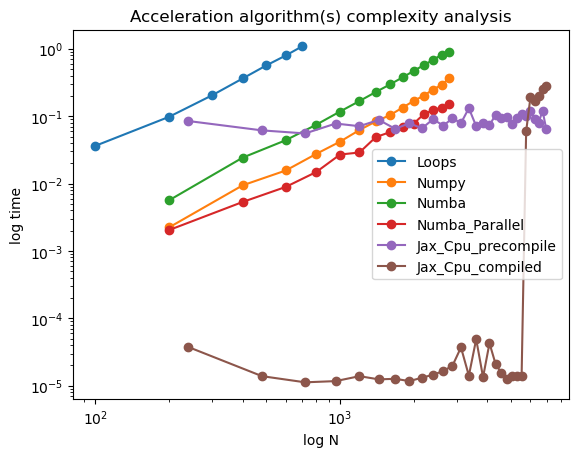

In [ ]:
plot_complexity(algorithms_complexity)

We run the code also in a Collab environment to have a gpu available, since the results don't differ too much between cpu and gpu we leave the code for gpu bellow but only show the cpu results so that we can have a full notebook with all the results together (Running the full notebook in collab will limit the number of threads to 2)

In [ ]:
try:
    algorithms_complexity["Jax_Gpu_precompile"] = verify_complexity(
        f_gpu,
        steps+15,
        starting_size+20,
    )

    algorithms_complexity["Jax_Gpu_compiled"] = verify_complexity(
        f_gpu,
        steps+15,
        starting_size+20,
    )
except:
    print("Gpu is not available")

Gpu is not available


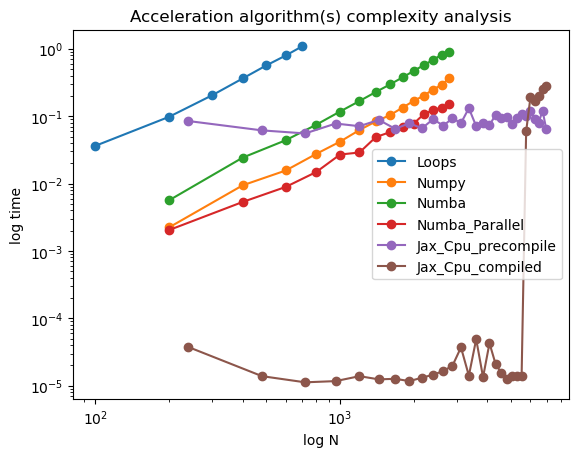

In [ ]:
plot_complexity(algorithms_complexity)